# Projection attempts

## 1. Logistic continuation
Assume that the whole population has to get infected. Use the most recent logistic r-values to project into the future.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scrape import entorb
import datetime


"""
Reproduction rate using logistic map

Args:
    df (DataFrame): data
    population (int): total infectable population
    generation_time: delay between infections in days

Return:
    DataFrame with reproduction rates for `Deaths` and `Cases`
"""
def polynomial_r(df, population = 83e6, generation_time=4):
    rs = pd.DataFrame()
    for col in ['Deaths', 'Cases']:
        normalized = df[col] / population
        earlier = normalized.shift(generation_time)
        rs[col] = normalized / (earlier - earlier**2)
    return rs

de = entorb.to_dataframe('DE-total')

col = 'Cases'
pop = 83e6

rs = polynomial_r(de)[col].dropna()

r1 = lambda x: rs.last('1D').mean()
r2 = lambda x: polynomial_r(de * 4)[col].last('1D').mean()
r3 = lambda x: rs.last('14D').mean()
r4 = lambda x: rs.last('7D').mean()

def plot_projection(r1,r2,r3,r4):
    xs = pd.date_range(start=de['Cases'].tail(1).index[0], periods=7*365/4, freq='4D')

    ys1 = list(de[col].rolling('1D').mean().tail(1).values)
    ys2 = list((de[col].rolling('1D').mean().tail(1)*4).values)
    ys3, ys4 = list(ys1), list(ys1)
    for i,x in enumerate(xs[:-1]):
        ys1.append(r1(i) * ys1[-1] * max(0, 1 - ys1[-1]/pop))
        ys2.append(r2(i) * ys2[-1] * max(0, 1 - ys2[-1]/pop))
        ys3.append(r3(i) * ys3[-1] * max(0, 1 - ys3[-1]/pop))
        ys4.append(r4(i) * ys4[-1] * max(0, 1 - ys4[-1]/pop))

    projection = pd.DataFrame({'Date': xs,
                               "Projection 4x(Cases last1D(r))=%.3f" % r2(i): ys2,
                               "Projection last14D(r)=%.3f" % r3(i): ys3,
                               "Projection last7D(r)=%.3f" % r4(i): ys4,
                               "Projection last1D(r)=%.3f" % r1(i): ys1,
                              }).set_index('Date')
    _log=False
    fig, axes = plt.subplots(nrows=2, sharex=True, figsize=(10,9))
    
    de[col].rolling('1D').mean().plot(ax=axes[0], logy=_log)
    (de[col].rolling('1D').mean() * 4).plot(ax=axes[0], logy=_log, label='4xCases', style='-')
    projection.plot(ax=axes[0])
    
    (de[col] - de[col].shift(4)).rolling('7D').mean().plot(ax=axes[1], logy=_log)
    ((de[col] - de[col].shift(4)).rolling('7D').mean() * 4).plot(ax=axes[1], logy=_log, label="4x%s"%col)
    (projection - projection.shift(1)).plot(ax=axes[1])

    for index, ax in enumerate(axes):
        if index==1:
            ax.legend(handles=ax.lines, loc='best')
            # ax.set_ylim(None, (de[col] - de[col].shift(4)).rolling('7D').mean().max()*4)
        ax.grid()

    now = datetime.datetime.now()
    fig.suptitle(("COVID-19 spread projection using Logistic map assuming a carrying capacity of K=%dM people.\n"
                  "created: %d-%02d-%02d, "
                  "author: @pschwede, "
                  "source: JHU CSSE via @entorb & @pomber.") % (pop/1e6, now.year, now.month, now.day))
    fig.set_facecolor('w')
    fig.tight_layout(rect=(0, 0.03, 1, 0.95))

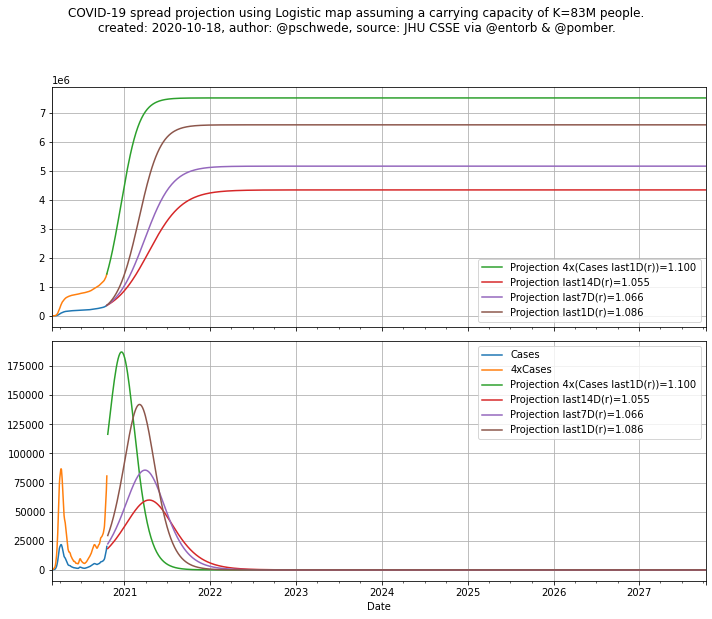

In [2]:
plot_projection(r1,r2,r3,r4)